In this notebook, we implement the out-of-distribution detection methods described in the article ["A baseline for detecting misclassified and out-of-distribution examples in neural networks"](https://arxiv.org/pdf/1610.02136.pdf)

## Imports

In [ ]:
! pip install datasets
! pip install transformers
! pip install evaluate
! pip install rouge_score

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import torch
import numpy as np
import evaluate
import copy

from datasets import load_dataset, load_metric
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, EncoderDecoderModel
from tqdm.auto import tqdm

## Baseline with anomaly scores and AUROC

In [3]:
in_dataset = load_dataset("yelp_review_full")
out_dataset = load_dataset("paws","labeled_final")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function_text(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

def tokenize_function_sentence1(examples):
    return tokenizer(examples['sentence1'], padding="max_length", truncation=True)
	

tokenized_in_dataset = in_dataset.map(tokenize_function_text, batched=True)
tokenized_out_dataset = out_dataset.map(tokenize_function_sentence1, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
tokenized_in_dataset = tokenized_in_dataset.remove_columns(["text"])
tokenized_in_dataset = tokenized_in_dataset.rename_column("label", "labels")
tokenized_in_dataset.set_format("torch")

tokenized_out_dataset = tokenized_out_dataset.remove_columns(["id","sentence1","sentence2"])
tokenized_out_dataset = tokenized_out_dataset.rename_column("label", "labels")
tokenized_out_dataset.set_format("torch")

In [6]:
small_train_dataset = tokenized_in_dataset["train"].shuffle(seed=42).select(range(10000))
small_in_eval_dataset = tokenized_in_dataset["test"].shuffle(seed=42).select(range(1000))
small_out_eval_dataset = tokenized_out_dataset["test"].shuffle(seed=42).select(range(1000))

In [7]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
in_eval_dataloader = DataLoader(small_in_eval_dataset, batch_size=8)
out_eval_dataloader = DataLoader(small_out_eval_dataset, batch_size=8)

In [8]:
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=5)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [10]:
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [11]:
progress_bar = tqdm(range(num_training_steps))
device='cpu'

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/3750 [00:00<?, ?it/s]

In [16]:
model.save_pretrained('pretrained_save_base')

In [17]:
metric = evaluate.load("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(in_eval_dataloader), desc="evaluating", total=in_eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

{'accuracy': 0.531}

In [18]:
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       220
           1       0.51      0.48      0.49       213
           2       0.42      0.52      0.46       196
           3       0.50      0.35      0.41       205
           4       0.57      0.64      0.60       166

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



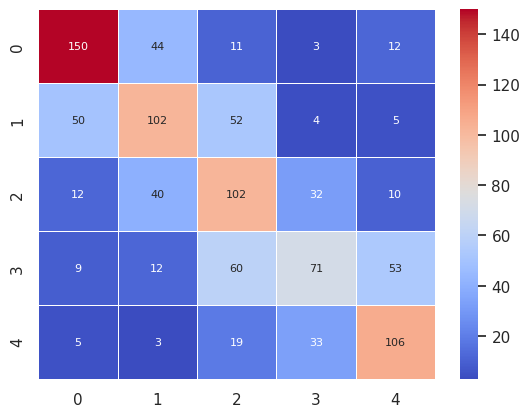

In [19]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [20]:
metric = evaluate.load("accuracy")
model.eval()
preds, trues = [], []
confidence_in=[]
confidence_out=[]
for i, batch in tqdm(enumerate(in_eval_dataloader), desc="evaluating", total=in_eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    softmaxx=torch.nn.functional.softmax(logits).max()
    confidence_in.append(float(softmaxx))
for i, batch in tqdm(enumerate(out_eval_dataloader), desc="evaluating", total=out_eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    softmaxx=torch.nn.functional.softmax(logits).max()
    confidence_out.append(float(softmaxx))

evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-20-66f4793781ce>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxx=torch.nn.functional.softmax(logits).max()


evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-20-66f4793781ce>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxx=torch.nn.functional.softmax(logits).max()


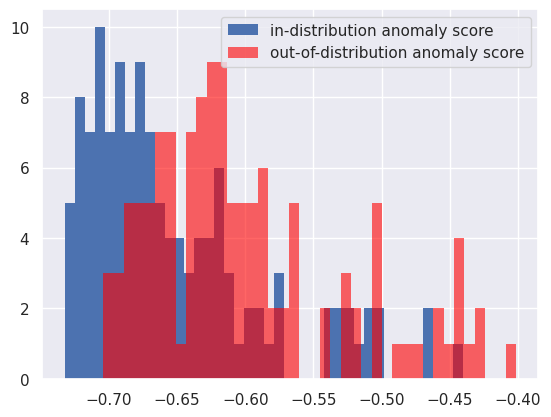

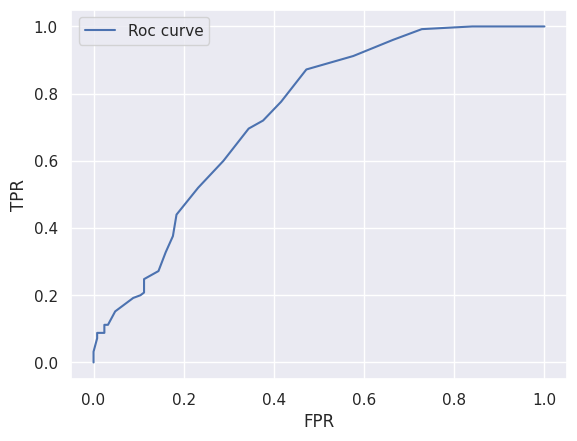

AUROC (ie ability to distinguish OOD examples):  0.756224


In [21]:
anomaly_in=[-x for x in confidence_in]
anomaly_out=[-x for x in confidence_out]

plt.hist(anomaly_in,bins=40,label='in-distribution anomaly score',edgecolor='none')
plt.hist(anomaly_out,bins=40,label='out-of-distribution anomaly score',edgecolor='none', alpha=0.6,color='red')
plt.legend()
plt.show()

tpr,fpr=[],[]
auroc=0
for i in range(100):
    threshold=-i/100
    tp=len([x for x in anomaly_out if x>threshold])
    fn=len([x for x in anomaly_out if x<threshold])
    tn=len([x for x in anomaly_in if x<threshold])
    fp=len([x for x in anomaly_in if x>threshold])
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
    if i!=0:
      auroc+=tpr[-1]*(fpr[-1]-fpr[-2])
plt.plot(fpr,tpr,label="Roc curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()
print("AUROC (ie ability to distinguish OOD examples): ",auroc)

## Better method with decoder

In [30]:
def new_label(example):
    example["labels"] = example["input_ids"]#.float()
    return example

tokenized_in_dataset_for_decoder = tokenized_in_dataset.map(new_label)
tokenized_out_dataset_for_decoder = tokenized_out_dataset.map(new_label)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/49401 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [31]:
small_train_dataset_for_decoder = tokenized_in_dataset_for_decoder["train"].shuffle(seed=42).select(range(2000))
small_in_eval_dataset_for_decoder = tokenized_in_dataset_for_decoder["test"].shuffle(seed=42).select(range(1000))
small_out_eval_dataset_for_decoder = tokenized_out_dataset_for_decoder["test"].shuffle(seed=42).select(range(1000))


train_dataloader_for_decoder = DataLoader(small_train_dataset_for_decoder, shuffle=True, batch_size=8)
in_eval_dataloader_for_decoder = DataLoader(small_in_eval_dataset_for_decoder, shuffle=True, batch_size=8)
out_eval_dataloader_for_decoder = DataLoader(small_out_eval_dataset_for_decoder, shuffle=True, batch_size=8)

In [32]:
model4=copy.deepcopy(model)
model4.classifier=torch.nn.Identity()

In [33]:
model4.save_pretrained('pretrained_save_sans_classifier')

In [34]:
encoder_decoder_model = EncoderDecoderModel.from_encoder_decoder_pretrained("pretrained_save_sans_classifier", "prajjwal1/bert-tiny")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert

In [35]:
params_to_update=[]
for name,param in encoder_decoder_model.named_parameters():
    if name[:7]=="decoder":
        params_to_update.append(param)
        param.requires_grad = True
    elif name[:7]=="encoder":
        param.requires_grad = False

In [36]:
encoder_decoder_model.config.decoder_start_token_id = tokenizer.cls_token_id
encoder_decoder_model.config.pad_token_id = tokenizer.pad_token_id

optimizer = AdamW(params_to_update, lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader_for_decoder)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))
encoder_decoder_model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader_for_decoder:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = encoder_decoder_model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)  

  0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [40]:
encoder_decoder_model.save_pretrained('pretrained_encoder_decoder')

In [41]:
rouge = evaluate.load("rouge")


def generate_sentence(batch):
    inputs = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    outputs = encoder_decoder_model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    batch["pred_sentence"] = output_str
    return batch

in_test_dataset=in_dataset['test'].shuffle(seed=42).select(range(200))
results_in = in_test_dataset.map(generate_sentence, batched=True, batch_size=8)

rouge.compute(predictions=results_in["pred_sentence"], references=results_in["text"], rouge_types=["rouge2"])["rouge2"]#.mid

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

0.0

In [ ]:
def generate_sentence2(batch):
    inputs = tokenizer(batch["sentence1"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids#.to("cuda")
    attention_mask = inputs.attention_mask#.to("cuda")
    outputs = encoder_decoder_model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    batch["pred_sentence"] = output_str
    return batch

out_test_dataset=out_dataset['test'].shuffle(seed=42).select(range(200))
results_out = out_test_dataset.map(generate_sentence2, batched=True, batch_size=8)

rouge.compute(predictions=results_out["pred_sentence"], references=results_out["sentence1"], rouge_types=["rouge2"])["rouge2"]#.mid
